In [36]:
import warnings
from os.path import join, basename, splitext
from glob import glob
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import raster as rt

In [2]:
locations = pd.read_csv("litvak_locations.csv")
locations

,tower,lat,lon
0,US-Seg,34.362300,-106.701900
1,US-Ses,34.334900,-106.744200
2,US-Wjs,34.425489,-105.861545
3,US-Mpj,34.438500,-106.237700
4,US-Vcp,35.864231,-106.596664
5,US-Vcm,35.888447,-106.432114
6,US-Vcs,35.919300,-106.614200


In [25]:
image_directory = "/Users/halverso/Downloads/VIIRS_GEOS5FP_output"
image_filenames = glob(join(image_directory, "**", "*.tif"), recursive=True)
image_filenames

['/Users/halverso/Downloads/VIIRS_GEOS5FP_output/2021-04-30/VIIRS-GEOS5FP_2021-04-30_13SCV/VIIRS-GEOS5FP_2021.04.30.20.36.24_13SCV_ST.tif',
 '/Users/halverso/Downloads/VIIRS_GEOS5FP_output/2021-04-30/VIIRS-GEOS5FP_2021-04-30_13SCV/VIIRS-GEOS5FP_2021.04.30.20.36.24_13SCV_water.tif',
 '/Users/halverso/Downloads/VIIRS_GEOS5FP_output/2021-04-30/VIIRS-GEOS5FP_2021-04-30_13SCV/VIIRS-GEOS5FP_2021.04.30.20.36.24_13SCV_LE.tif',
 '/Users/halverso/Downloads/VIIRS_GEOS5FP_output/2021-04-30/VIIRS-GEOS5FP_2021-04-30_13SCV/VIIRS-GEOS5FP_2021.04.30.20.36.24_13SCV_albedo.tif',
 '/Users/halverso/Downloads/VIIRS_GEOS5FP_output/2021-04-30/VIIRS-GEOS5FP_2021-04-30_13SCV/VIIRS-GEOS5FP_2021.04.30.20.36.24_13SCV_Ta.tif',
 '/Users/halverso/Downloads/VIIRS_GEOS5FP_output/2021-04-30/VIIRS-GEOS5FP_2021-04-30_13SCV/VIIRS-GEOS5FP_2021.04.30.20.36.24_13SCV_ESI.tif',
 '/Users/halverso/Downloads/VIIRS_GEOS5FP_output/2021-04-30/VIIRS-GEOS5FP_2021-04-30_13SCV/VIIRS-GEOS5FP_2021.04.30.20.36.24_13SCV_SWin.tif',
 '/Users/h

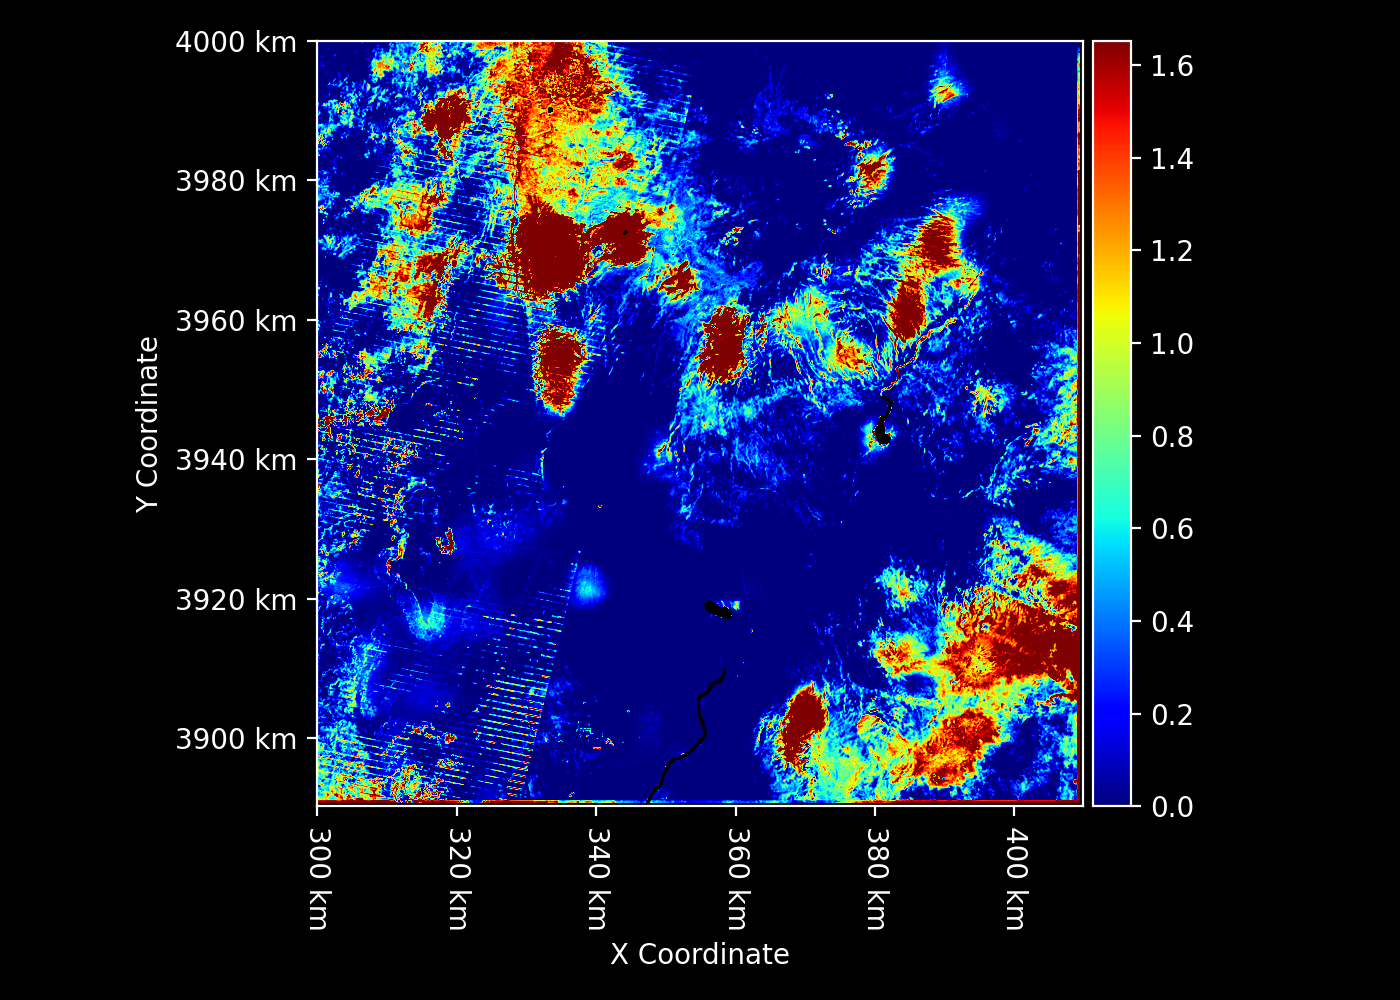

In [4]:
image_filename = "/Users/halverso/Downloads/VIIRS-GEOS5FP_2021.04.30.20.36.24_13SCV_ET.tif"
image = rt.Raster.open(image_filename)
image

In [38]:
table_rows = []

for image_filename in image_filenames:
    # print(basename(image_filename))
    variable = splitext(basename(image_filename))[0].split("_")[-1]
    time_UTC = datetime.strptime(splitext(basename(image_filename))[0].split("_")[-3], "%Y.%m.%d.%H.%M.%S")
    
    for i, (tower, lat, lon) in locations.iterrows():
        time_solar = time_UTC + timedelta(hours=(np.radians(lon) / np.pi * 12))
        tower_point_latlon = rt.Point(lon, lat)
        
        if not image.geometry.intersects(tower_point_latlon.to_crs(image.geometry.crs)):
            # print(f"image does not intersect {tower} tower: {image_filename}")
            continue
        
        tower_row, tower_col = image.geometry.index_point(tower_point_latlon.to_crs(image.geometry.crs))
        rows, cols = image.geometry.shape

        if tower_row > rows or tower_row < 0 or tower_col > cols or tower_col < 0:
            # print(f"image does not intersect {tower} tower: {image_filename}")
            continue
        
        # print(f"extracting tower {tower} at lat {lat} lon {lon} from image: {image_filename}")

        # print(f"tower cell index: [{tower_row}, {tower_col}]")
        # print(f"tower shape: [{rows}, {cols}]")
        
        min_row = max(tower_row - 1, 0)
        max_row = min(tower_row + 2, rows - 1)
        min_col = max(tower_col - 1, 0)
        max_col = min(tower_col + 2, cols - 1)
        # print(f"3x3 subset index: [{min_row}:{max_row}, {min_col}:{max_col}]")
        subset_3x3 = image.geometry[min_row:max_row, min_col:max_col]
        subset_image = rt.Raster.open(image_filename, geometry=subset_3x3)
        # print(subset_image)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            median_value = np.nanmedian(subset_image)

        # print(f"median value: {median_value}")

        if np.isnan(median_value):
            continue

        print(tower, lat, lon, time_UTC, time_solar, variable, median_value)
        table_rows.append([tower, lat, lon, time_UTC,
                          time_solar, variable, median_value])

df = pd.DataFrame(table_rows, columns=[
                  "tower", "lat", "lon", "time_UTC", "time_solar", "variable", "med3x3"])
df.to_csv("calval.csv", index=False)
df


US-Vcp 35.864231 -106.596664 2021-04-30 20:36:24 2021-04-30 13:30:00.800640 ST 18.989635
US-Vcm 35.888447 -106.432114 2021-04-30 20:36:24 2021-04-30 13:30:40.292640 ST 31.48307
US-Vcs 35.9193 -106.6142 2021-04-30 20:36:24 2021-04-30 13:29:56.592000 ST 22.237387
US-Vcp 35.864231 -106.596664 2021-04-30 20:36:24 2021-04-30 13:30:00.800640 water 0.0
US-Vcm 35.888447 -106.432114 2021-04-30 20:36:24 2021-04-30 13:30:40.292640 water 0.0
US-Vcs 35.9193 -106.6142 2021-04-30 20:36:24 2021-04-30 13:29:56.592000 water 0.0
US-Vcp 35.864231 -106.596664 2021-04-30 20:36:24 2021-04-30 13:30:00.800640 LE 20.564522
US-Vcm 35.888447 -106.432114 2021-04-30 20:36:24 2021-04-30 13:30:40.292640 LE 0.12163119
US-Vcs 35.9193 -106.6142 2021-04-30 20:36:24 2021-04-30 13:29:56.592000 LE 18.20007
US-Vcp 35.864231 -106.596664 2021-04-30 20:36:24 2021-04-30 13:30:00.800640 albedo 0.035456736
US-Vcm 35.888447 -106.432114 2021-04-30 20:36:24 2021-04-30 13:30:40.292640 albedo 0.15587287
US-Vcs 35.9193 -106.6142 2021-04

,tower,lat,lon,time_UTC,time_solar,variable,med3x3
0,US-Vcp,35.864231,-106.596664,2021-04-30 20:36:24,2021-04-30 13:30:00.800640,ST,18.989635
1,US-Vcm,35.888447,-106.432114,2021-04-30 20:36:24,2021-04-30 13:30:40.292640,ST,31.483070
2,US-Vcs,35.919300,-106.614200,2021-04-30 20:36:24,2021-04-30 13:29:56.592000,ST,22.237387
3,US-Vcp,35.864231,-106.596664,2021-04-30 20:36:24,2021-04-30 13:30:00.800640,water,0.000000
4,US-Vcm,35.888447,-106.432114,2021-04-30 20:36:24,2021-04-30 13:30:40.292640,water,0.000000
5,US-Vcs,35.919300,-106.614200,2021-04-30 20:36:24,2021-04-30 13:29:56.592000,water,0.000000
6,US-Vcp,35.864231,-106.596664,2021-04-30 20:36:24,2021-04-30 13:30:00.800640,LE,20.564522
7,US-Vcm,35.888447,-106.432114,2021-04-30 20:36:24,2021-04-30 13:30:40.292640,LE,0.121631
8,US-Vcs,35.919300,-106.614200,2021-04-30 20:36:24,2021-04-30 13:29:56.592000,LE,18.200069
9,US-Vcp,35.864231,-106.596664,2021-04-30 20:36:24,2021-04-30 13:30:00.800640,albedo,0.035457
